# Funnel dimension sweep

In [3]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
import kernels
import metrics

from tqdm import tqdm
key = random.PRNGKey(0)

# import seaborn as sns
# sns.set_theme()

# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# High-dim Funnel

In [30]:
NUM_STEPS = 500
PARTICLE_STEP_SIZE = 1e-2
LEARNING_RATE = 1e-4
NUM_PARTICLES = 100
d = 50
# PATIENCE = 0
PATIENCE = 20 # try this
LEARNER_STEPS = 150
sizes = [128, 128, 128, d]
target_moment2 = np.array([9] + (d-1)*[90])

In [31]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(NUM_PARTICLES)

In [32]:
def plot_true(idx=np.array([0, -1]), ax=None):
    if ax is None:
        ax = plt.gca()
    lims=(-15, 15)
    ax.set(xlim=lims, ylim=lims)
    ax.scatter(*np.rollaxis(target_samples[:, idx], 1), alpha=0.25, label="True", marker=".")

In [127]:
bias_tracer = metrics.get_2nd_moment_tracer(target_moment2)
funnel_mmd_tracer = metrics.get_funnel_tracer(target_samples)
mmd_tracer = metrics.get_mmd_tracer(target_samples)

In [129]:
tracer = metrics.combine_tracers(bias_tracer, funnel_mmd_tracer, mmd_tracer)

In [130]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=NUM_PARTICLES, n_steps=NUM_STEPS, particle_lr=PARTICLE_STEP_SIZE, patience=PATIENCE, learner_lr=LEARNING_RATE, aux=False, compute_metrics=tracer, n_learner_steps=LEARNER_STEPS, sizes=sizes)
svgd_gradient, svgd_particles, err4    = flows.svgd_flow(       subkey, funnel_setup, n_particles=NUM_PARTICLES, n_steps=NUM_STEPS, particle_lr=PARTICLE_STEP_SIZE, scaled=True,  bandwidth=None, compute_metrics=tracer)
sgld_gradient, sgld_particles, err2    = flows.sgld_flow(       subkey, funnel_setup, n_particles=NUM_PARTICLES, n_steps=NUM_STEPS, particle_lr=PARTICLE_STEP_SIZE, compute_metrics=tracer)
# sgld_gradient2, sgld_particles2, err3  = flows.sgld_flow(       subkey, funnel_setup, n_particles=NUM_PARTICLES, n_steps=NUM_STEPS, particle_lr=PARTICLE_STEP_SIZE/5, compute_metrics=metrics.get_2nd_moment_tracer(target_moment2))



KeyboardInterrupt: 

In [ ]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

In [ ]:
def plot_projection(idx):
    true_samples = target.sample(NUM_PARTICLES)
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, svgd_particles)]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:100, idx], 1), alpha=0.85)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

# interlude: sanity check the funnel MMD

In [55]:
true_samples = target.sample(100)

In [54]:
mmd = metrics.get_mmd(kernel=kernels.get_funnel_kernel(1.))

In [56]:
neural_particles.particles.training

(100, 50)

In [57]:
mmd(neural_particles.particles.training, true_samples)

DeviceArray(3.2972174e-14, dtype=float32)

In [57]:
mmd(neural_particles.particles.training, true_samples)

DeviceArray(3.2972174e-14, dtype=float32)

In [1]:
# transform back to gaussian
true_dfized = vmap(kernels.defunnelize)(true_samples)
neur_dfized = vmap(kernels.defunnelize)(neural_particles.particles.training)
svgd_dfized = vmap(kernels.defunnelize)(svgd_particles.particles.training)
sgld_dfized = vmap(kernels.defunnelize)(sgld_particles.particles.training)

NameError: name 'vmap' is not defined

In [106]:
standardsamples = random.normal(subkey, (1000,50))

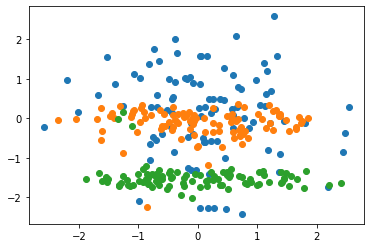

In [126]:
i=0
j=-1
idx = onp.array([i, j])

fig, ax = plt.subplots()
plot.scatter(true_dfized[:, idx])
plot.scatter(neur_dfized[:, idx], label="neural")
plot.scatter(svgd_dfized[:, idx], label="svgd")
plot.scatter(sgld_dfized[:, idx], label="langevin")
# plot.scatter(random.normal(subkey, (100, 2)))

In [103]:
mmd_gauss = metrics.get_mmd(kernels.get_rbf_kernel(1.))
mmd_gauss(true_dfized, neur_dfized)

DeviceArray(3.297218e-14, dtype=float32)

In [108]:
mmd_gauss(neur_dfized, standardsamples)

DeviceArray(1.0564843e-12, dtype=float32)

In [90]:
mmd_x = metrics.get_mmd(kernels.get_tophat_kernel(10))
mmd_x(true_dfized, neur_dfized)

DeviceArray(0., dtype=float32)

# back to your regular programming

In [ ]:
%matplotlib inline
lims=(-15, 15)

idx = np.array([0, -1])
plot_projection(idx)

In [ ]:
idx = np.array([0, 1])
plot_projection(idx)

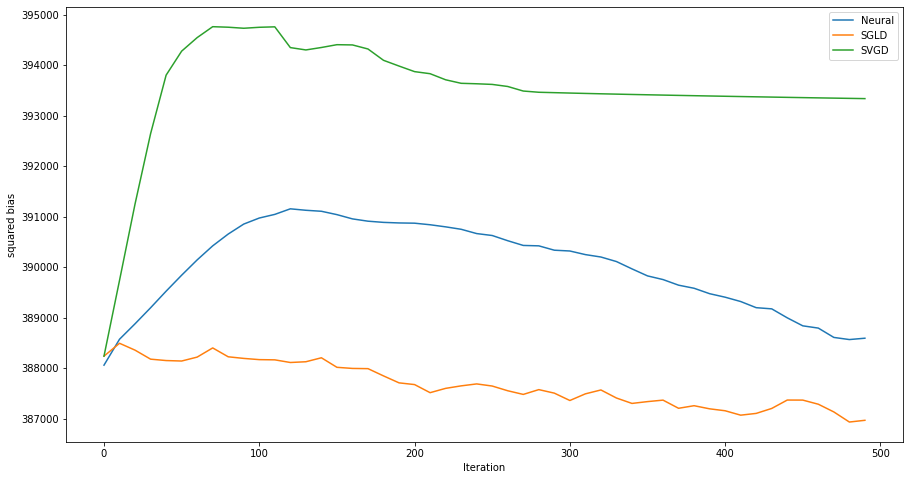

In [133]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles.rundata["second_error"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["second_error"]), label="SGLD")
# plt.plot(*zip(*sgld_particles2_d.rundata["second_error"]), label="SGLD (reduced step-size)")
plt.plot(*zip(*svgd_particles.rundata["second_error"]), label="SVGD")
# plt.yscale("symlog")

plt.xlabel("Iteration")
plt.ylabel("squared bias")

plt.legend()

In [ ]:
neural_particles.rundata.keys()

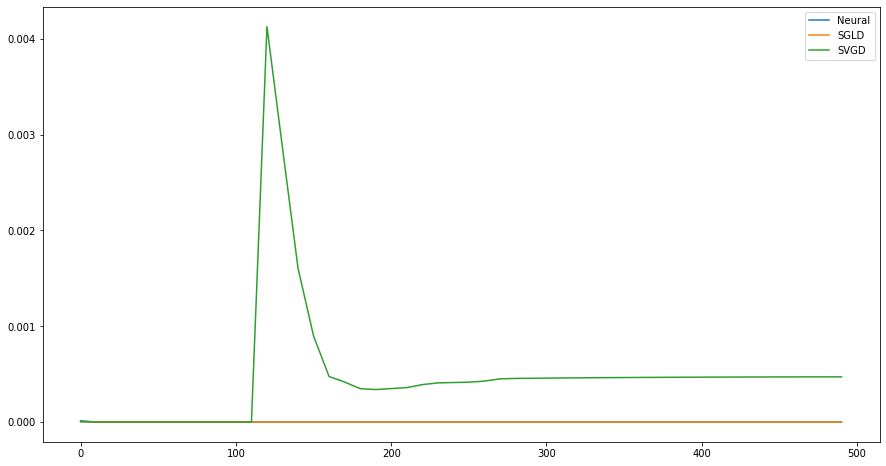

In [132]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles.rundata["funnel_mmd"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["funnel_mmd"]), label="SGLD")
plt.plot(*zip(*svgd_particles.rundata["funnel_mmd"]), label="SVGD")

plt.legend()

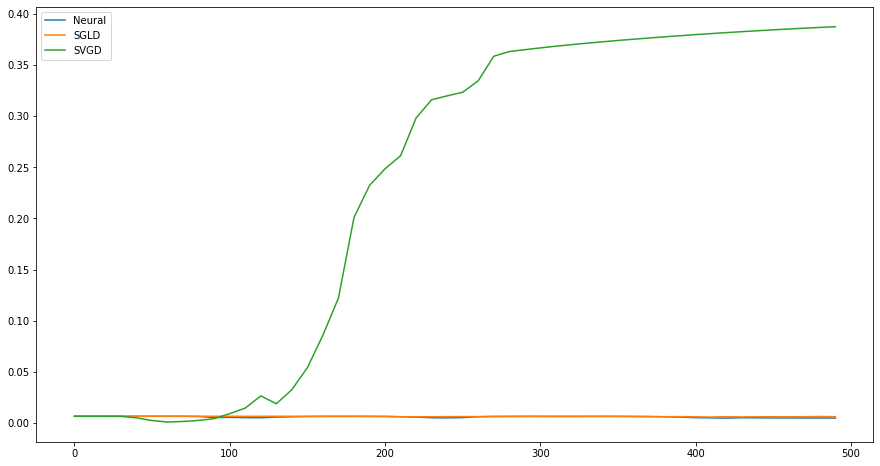

In [134]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

plt.plot(*zip(*neural_particles.rundata["rbf_mmd"]), label="Neural")
plt.plot(*zip(*sgld_particles.rundata["rbf_mmd"]), label="SGLD")
plt.plot(*zip(*svgd_particles.rundata["rbf_mmd"]), label="SVGD")

plt.legend()

### neural metrics

In [ ]:
s = proposal.sample(1000)
optimal_sd0 = utils.l2_norm_squared(s, grad(lambda x: target.logpdf(x) - proposal.logpdf(x)))
optimal_sd0

In [ ]:
%matplotlib widget
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_sd"])
plt.plot(neural_learner.rundata["validation_sd"])

In [ ]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

### animate projection

In [ ]:
idx = np.array([0, -1])

In [ ]:
neural_particles.done()

In [ ]:
%matplotlib widget
lims = (-15, 15)
fig, axs = plt.subplots(1, 3, figsize=[25,8])
for ax in axs:
    ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
    ax.set(xlim=lims, ylim=lims)

a=[]
a.append(plot.animate_array(neural_particles.rundata["particles"].training[:, :, idx], fig, ax=axs[0], interval=10))
a.append(plot.animate_array(  sgld_particles.rundata["particles"].training[:, :, idx], fig, ax=axs[1], interval=10))
# a.append(plot.animate_array(sgld_particles2.rundata["particles"].training, ax=axs[2], interval=10**3))
a

# Sweep starts here

## Metric

In [4]:
rbf = kernels.get_rbf_kernel(1.)
# funnel = kernels.get_funnel_kernel(1.)
# mix = lambda x, y: rbf(x, y) + funnel(x, y)
mmd = jit(metrics.get_mmd(rbf))

In [9]:
# da = distributions.Gaussian(0, 1)
# db = distributions.Gaussian(0, 2)

# key, keya, keyb = random.split(key, 3)
# xs = da.sample(1000, keya)
# ys = db.sample(1000, keyb)
# mmd(xs, ys)

## Sweep

In [8]:
n_steps = 500
particle_lr = 1e-2
learner_lr = 1e-4

In [9]:
def sample(d, key, n_particles):
    target = distributions.Funnel(d)
    proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
    funnel_setup = distributions.Setup(target, proposal)

    key, subkey = random.split(key)
    neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., patience=0, learner_lr=learner_lr)
    svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
    sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)
    
    return (neural_particles, svgd_particles, sgld_particles), (neural_learner, svgd_gradient, sgld_gradient)

In [10]:
def get_mmds(particle_list, ys):
    mmds = []
    for xs in [p.particles.training for p in particle_list]:
        mmds.append(mmd(xs, ys))
    return mmds

In [11]:
mmd_sweep = []
key, subkey = random.split(key)
n_particles = 100

In [ ]:
for d in tqdm(range(2, 25), disable=True):
    print(d)
    key, subkey = random.split(key)
    particles, gradients = sample(d, subkey, n_particles)
    target = distributions.Funnel(d)
    key, subkey = random.split(key)
    ys = target.sample(n_particles, subkey)
    mmds = get_mmds(particles, ys)
    mmd_sweep.append(mmds)

15


100%|██████████| 500/500 [00:07<00:00, 66.61it/s]


16


100%|██████████| 500/500 [00:08<00:00, 61.62it/s]


17


100%|██████████| 500/500 [00:08<00:00, 55.93it/s]


18


 96%|█████████▌| 480/500 [00:43<00:03,  5.11it/s]

In [ ]:
plt.subplots(figsize=[15, 5])
names = "Neural SVGD SGLD".split()
lines = plt.plot(mmd_sweep, "--.")
for name, line in zip(names, lines):
    line.set_label(name)
    
plt.ylabel("MMD(samples, target)")
plt.xlabel("Dimensionality of sample space")
plt.legend()
# plt.yscale("log")

In [ ]:
# plt.subplots(figsize=printsize)
# names = "Neural SVGD SGLD".split()
# lines = plt.plot(mmd_sweep, "--.")
# for name, line in zip(names, lines):
#     line.set_label(name)
# plt.legend()
# plt.ylabel("MMD(samples, target)")
# plt.xlabel("Dimensionality of sample space")
# plt.savefig(figure_path + "funnel-dimension-sweep.pgf")

## plots

In [ ]:
%matplotlib inline
lims=(-15, 15)
def plot_projection(idx):
    true_samples = target.sample(1000)
    sample_list = [p.particles.training for p in particles]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        print(samples.shape)
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.15, label="True")
        ax.scatter(*np.rollaxis(samples[:, idx], 1), alpha=0.15)
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

idx = np.array([2, -1])
plot_projection(idx)